# Cascade of two-neuron modules
*Nhat Le, November 2017*

In [240]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [2]:
def ecdf(x):
    return np.sort(x), np.arange(len(x)) / len(x)

def save_safe(filename):
    '''Raise an error if file exists'''
    if not os.path.isfile(filename):
        plt.savefig(filename)
    else:
        raise IOError('File exists!')

def thresh_exp(x):
    '''Activation function'''
    return 1 / (1 + np.exp(-x))

def find_u_dot(state, params):
    '''Returns du/dt given the parameters and current state'''
    Wuv = params['Wuv']
    Wut = params['Wut']
    tau = params['tau']
    ext = params['ext']
    theta = params['theta']
    
    u = state['u']
    v = state['v']
    return (-u + thresh_exp(Wut * theta - Wuv * v + ext)) / tau

def find_v_dot(state, params):
    '''Returns dv/dt given the parameters and current state'''
    Wvu = params['Wvu']
    Wvt = params['Wvt']
    tau = params['tau']
    ext = params['ext']
    theta = params['theta']

    
    u = state['u']
    v = state['v']
    return (-v + thresh_exp(Wvt * theta - Wvu * u + ext)) / tau

def update_u_exp(state, params):
    '''Update u based on params'''
    state_new = state.copy()
    state_new['u'] += find_u_dot(state, params) * params['dt']
    return state_new

def update_v_exp(state, params):
    '''Update v based on params'''
    state_new = state.copy()
    state_new['v'] += find_v_dot(state, params) * params['dt']
    return state_new

def simulate_u_v_exp(state_init, params, niter):
    '''Simulate for niter iterations'''
    curr_state = state_init.copy()
    u_lst = [state_init['u']]
    v_lst = [state_init['v']]

    for i in range(niter):
        order = np.random.randint(0, 2)
        if order:
            curr_state = update_u_exp(curr_state, params)    
            curr_state = update_v_exp(curr_state, params)
        else:
            curr_state = update_v_exp(curr_state, params)    
            curr_state = update_u_exp(curr_state, params)
        v_lst.append(curr_state['v'])
        u_lst.append(curr_state['u'])
    return u_lst, v_lst

def find_u_dot_multi(state, params):
    '''Returns du/dt given the parameters and current state'''
    u = state['u']
    v = state['v']
    Wuv = params['Wuv']
    Wut = params['Wut']
    tau = params['tau']
    ext = params['ext']
    theta = params['theta']
    sigma = params['sigma']
        
    noise = np.random.normal(loc=0, scale=sigma, size=len(u))
    return (-u + thresh_exp(Wut * theta - Wuv * v + noise + ext)) / tau

def find_v_dot_multi(state, params):
    '''Returns dv/dt given the parameters and current state'''
    u = state['u']
    v = state['v']
    Wvu = params['Wvu']
    Wvt = params['Wvt']
    tau = params['tau']
    ext = params['ext']
    theta = params['theta']
    sigma = params['sigma']
        
    noise = np.random.normal(loc=0, scale=sigma, size=len(v))
    return (-v + thresh_exp(Wvt * theta - Wvu * u + noise + ext)) / tau

def update_u_exp_multi(state, params):
    '''Update u based on params'''
    state_new = state.copy()
    state_new['u']= state_new['u'] + find_u_dot_multi(state, params) * params['dt']
    return state_new

def update_v_exp_multi(state, params):
    '''Update v based on params'''
    state_new = state.copy()
    state_new['v'] = state_new['v'] + find_v_dot_multi(state, params) * params['dt']
    return state_new

def simulate_u_v_exp_multi(state_init, params, niter):
    '''Simulate for niter iterations'''
    curr_state = state_init.copy()
    u_lst = [state_init['u']]
    v_lst = [state_init['v']]

    for i in range(niter):
        order = np.random.randint(0, 2) # Choose to update u or v first
        if order:
            curr_state = update_u_exp_multi(curr_state, params)
            curr_state = update_v_exp_multi(curr_state, params) 
        else:
            curr_state = update_v_exp_multi(curr_state, params)
            curr_state = update_u_exp_multi(curr_state, params) 
        u_lst.append(curr_state['u'])
        v_lst.append(curr_state['v'])
        
    u_arr = np.vstack(u_lst)
    v_arr = np.vstack(v_lst)
    return u_arr, v_arr

def ecdf(data):
    return np.sort(data), np.arange(len(data)) / len(data)

def get_mean_and_sd_lines(state, params, nstep):
    '''Simulate for n steps and return two arrays, one for mean
    and one for SD across all trials'''
    ulst, vlst = simulate_u_v_exp_multi(state, params, nstep)
    return np.mean(ulst, axis=1), np.mean(vlst, axis=1), \
            np.std(ulst, axis=1), np.std(vlst, axis=1)

In [3]:
def get_times_lst(state, params, nsteps, threshold):
    '''Given a starting state and parameters,
    return the time(s) that the threshold is reached'''
    ulst, vlst = simulate_u_v_exp_multi(state, params, nsteps)
    decision_v = ulst - vlst
    
    times_lst = []
    
    # Find time to act
    for k in range(ntrials):
        # Check if the bound is reached (sometimes it's not!)
        if np.max(decision_v[:,k]) > threshold:
            times_lst.append(np.nonzero(decision_v[:, k] > thresh)[0][0])
        else:
            times_lst.append(np.inf)
            print('Bound not reached')
    
    return times_lst

## Effect of $\sigma_\mu$

In [222]:
def simulate_module(ntrials, nsteps, ext_lst, params, K, prev_final=np.array([]), ext_updating=False):
    '''Simulate a single module
    Returns the list of final positions'''
    ext_lst_new = np.array(ext_lst)
    if ext_updating:
        assert(prev_final.shape != (0,))
        ext_lst_new += K * (prev_final - np.mean(prev_final))
    params['ext'] = ext_lst_new
    state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
    ulst_noise, vlst_noise = simulate_u_v_exp_multi(state_dict, params, nsteps)
    return ext_lst_new, (ulst_noise - vlst_noise)[-1, :]

In [262]:
Kval = 3
# Module 1
ext_module1 = np.random.normal(loc=0, scale=0.3, size=ntrials)
param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module1, 'sigma': 0}
_, final_pos1 = simulate_module(100, 300, ext_module1, param_dict_module, K=Kval, ext_updating=False)

# Module 2
ext_module2, final_pos2 = simulate_module(100, 300, ext_module1, param_dict_module, 
                                          K=Kval, prev_final=final_pos1, ext_updating=True)

# Module3
ext_module3, final_pos3 = simulate_module(100, 300, ext_module2, param_dict_module, 
                                          K=Kval, prev_final=final_pos2, ext_updating=True)

In [209]:
# Module 1!
ntrials = 100
nsteps = 0
ext_module1 = np.random.normal(loc=0, scale=0.3, size=ntrials)
param_dict_module1 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module1, 'sigma': 0}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise1, vlst_noise1 = simulate_u_v_exp_multi(state_dict, param_dict_module1, 300)
final_pos1 = (ulst_noise1 - vlst_noise1)[-1, :]

In [ ]:
# Module 2!
ref2 = np.mean(final_pos1)
k2 = 2
ext_module2 = (ext_module1 + k2 * (final_pos1 - ref2))

param_dict_module2 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module2, 'sigma': 0}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise2, vlst_noise2 = simulate_u_v_exp_multi(state_dict, param_dict_module2, 300)
decision_v2 = ulst_noise2 - vlst_noise2
final_pos2 = (ulst_noise2 - vlst_noise2)[-1, :]

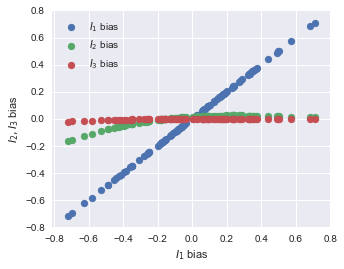

In [258]:
plt.figure(figsize=(5, 4))
plt.scatter(ext_module1, ext_module1, label=r'$I_1$ bias')
plt.scatter(ext_module1, ext_module2, label=r'$I_2$ bias')
plt.scatter(ext_module1, ext_module3, label=r'$I_3$ bias')
plt.xlabel(r'$I_1$ bias')
plt.ylabel(r'$I_2, I_3$ bias')
plt.legend()
save_safe('bias_three_modules_sigma_mu_K-4.pdf')

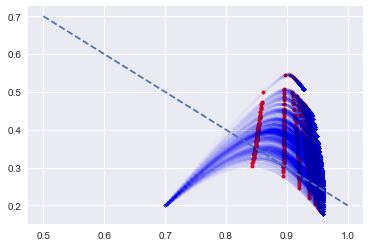

In [105]:
plt.plot(ulst_noise1, vlst_noise1, 'b.', alpha=0.01);
k = np.linspace(0.5, 1, 100)
plt.scatter(ulst_noise1[100,:], vlst_noise1[100,:], color='r', marker='.');
plt.scatter(ulst_noise1[200,:], vlst_noise1[200,:], color='r', marker='.');
plt.scatter(ulst_noise1[300,:], vlst_noise1[300,:], color='r', marker='.');
plt.scatter(ulst_noise1[400,:], vlst_noise1[400,:], color='r', marker='.');
plt.scatter(ulst_noise1[500,:], vlst_noise1[500,:], color='r', marker='.');
plt.scatter(ulst_noise1[600,:], vlst_noise1[600,:], color='r', marker='.');
plt.scatter(ulst_noise1[700,:], vlst_noise1[700,:], color='r', marker='.');
plt.scatter(ulst_noise1[800,:], vlst_noise1[800,:], color='r', marker='.');
plt.plot(k , 1 - k + 0.2, '--')

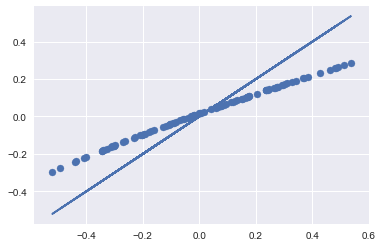

In [141]:
plt.scatter(ext_module1, ext_module2)
plt.plot(ext_module1, ext_module1)

In [140]:
# Module 2!
ref2 = np.mean(final_pos1)
k2 = 2
ext_module2 = (ext_module1 + k2 * (final_pos1 - ref2))

param_dict_module2 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module2, 'sigma': 0}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise2, vlst_noise2 = simulate_u_v_exp_multi(state_dict, param_dict_module2, 300)
decision_v2 = ulst_noise2 - vlst_noise2
final_pos2 = (ulst_noise2 - vlst_noise2)[-1, :]


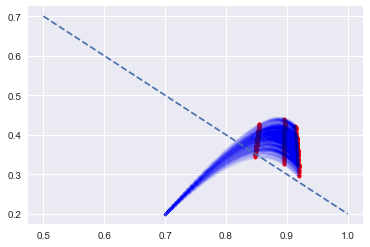

In [143]:
plt.plot(ulst_noise2, vlst_noise2, 'b.', alpha=0.01);
k = np.linspace(0.5, 1, 100)
plt.scatter(ulst_noise2[100,:], vlst_noise2[100,:], color='r', marker='.');
plt.scatter(ulst_noise2[200,:], vlst_noise2[200,:], color='r', marker='.');
plt.scatter(ulst_noise2[300,:], vlst_noise2[300,:], color='r', marker='.');

plt.plot(k , 1 - k + 0.2, '--')

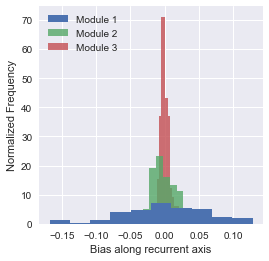

In [284]:
plt.figure(figsize=(4, 4))
plt.hist(final_pos1 - np.mean(final_pos1), normed=True, alpha=1, label='Module 1', zorder=5)
plt.hist(final_pos2 - np.mean(final_pos2), normed=True, alpha=0.8, label='Module 2', zorder=4)
plt.hist(final_pos3 - np.mean(final_pos3), normed=True, alpha=0.8, label='Module 3', zorder=3)
plt.xlabel('Bias along recurrent axis')
plt.ylabel('Normalized Frequency')
plt.legend(loc='upper left')
save_safe('bias_three_modules.pdf')

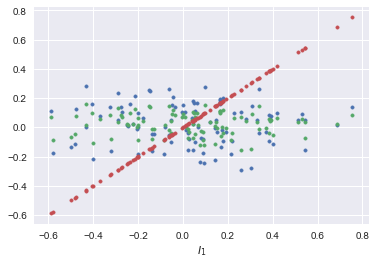

In [181]:
plt.scatter(ext_module1, ext_module2, marker='.')
plt.scatter(ext_module1, ext_module3, marker='.')
plt.scatter(ext_module1, ext_module1, marker='.')
plt.xlabel(r'$I_1$')

In [173]:
# Module 3!
ref3 = np.mean(final_pos2)
k3 = 2
ext_module3 = (ext_module2 + k3 * (final_pos2 - ref3))

param_dict_module3 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module3, 'sigma': 0}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise3, vlst_noise3 = simulate_u_v_exp_multi(state_dict, param_dict_module3, 400)
final_pos3 = (ulst_noise3 - vlst_noise3)[-1, :]
action_times = get_times_lst(state_dict, param_dict_module3, 1000, thresh)



NameError: name 'thresh' is not defined

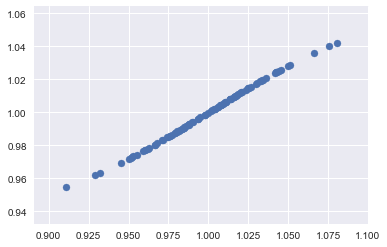

In [167]:
plt.scatter(final_pos1, final_pos2)

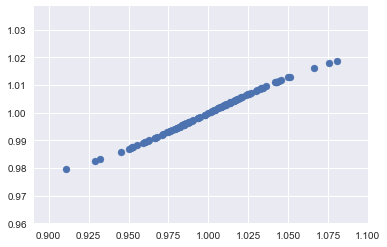

In [171]:
plt.scatter(final_pos1, final_pos3)

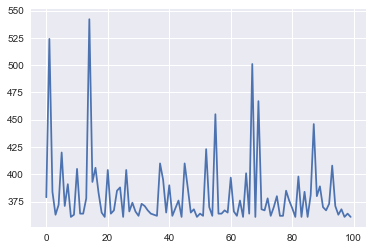

In [186]:
plt.plot(action_times2)

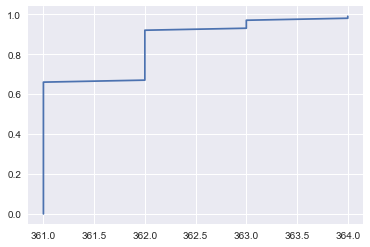

In [179]:
# Module 4 (readout)
ref4 = 1
k4 = 5
thresh = 0.8
ext_module4 = (ext_module3 - k4 * (final_pos3 - ref4))
param_dict_module4 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': ext_module4, 'sigma': 0}


action_times = get_times_lst(state_dict, param_dict_module4, 1000, thresh)
x, y = ecdf(action_times)
plt.plot(x, y)

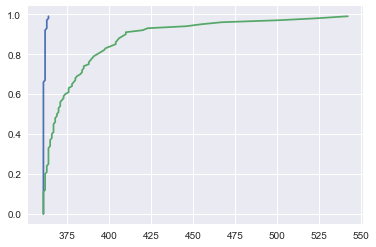

In [184]:
# Compare to a single module
action_times2 = get_times_lst(state_dict, param_dict_module1, 1000, thresh)
action_times = get_times_lst(state_dict, param_dict_module4, 1000, thresh)

x1, y1 = ecdf(action_times)
x2, y2 = ecdf(action_times2)
plt.plot(x1, y1)
plt.plot(x2, y2)

## Effect of $\sigma_\sigma$

In [50]:
# Module 1!
ntrials = 100
nsteps = 400
#ext_module1 = np.random.normal(loc=0, scale=0.1, size=ntrials)
param_dict_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': 0.6}
param_dict_no_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': 0}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise1, vlst_noise1 = simulate_u_v_exp_multi(state_dict, param_dict_noise, nsteps)
ulst_no_noise, vlst_no_noise = simulate_u_v_exp_multi(state_dict, param_dict_no_noise, nsteps)

decision_v = ulst_noise1 - vlst_noise1
final_pos = decision_v[-1]
ref_decision = np.mean(final_pos)

ext_lst = ref_decision - final_pos

In [57]:
# Module 2!
param_dict_noise['ext'] = ext_lst * 10
ulst_noise2, vlst_noise2 = simulate_u_v_exp_multi(state_dict, param_dict_noise, nsteps)

decision_v2 = ulst_noise2 - vlst_noise2
final_pos2 = decision_v2[-1]
ref_decision2 = np.mean(final_pos2)

ext_lst2 = ref_decision2 - final_pos2


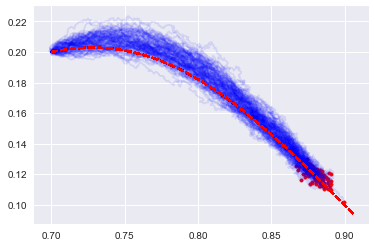

In [58]:
plt.plot(ulst_noise1, vlst_noise1, 'b', alpha=0.1);
plt.plot(ulst_no_noise, vlst_no_noise, 'r--');
plt.scatter(ulst_noise1[-1], vlst_noise1[-1], color='r', marker='.')

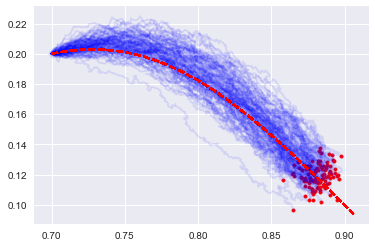

In [59]:
plt.plot(ulst_noise2, vlst_noise2, 'b', alpha=0.1);
plt.plot(ulst_no_noise, vlst_no_noise, 'r--');
plt.scatter(ulst_noise2[-1], vlst_noise2[-1], color='r', marker='.')

(array([  1.,   0.,   1.,   8.,  16.,  20.,  21.,  18.,   9.,   6.]),
 array([-0.03492101, -0.02924136, -0.0235617 , -0.01788205, -0.0122024 ,
        -0.00652275, -0.0008431 ,  0.00483655,  0.01051621,  0.01619586,
         0.02187551]),
 <a list of 10 Patch objects>)

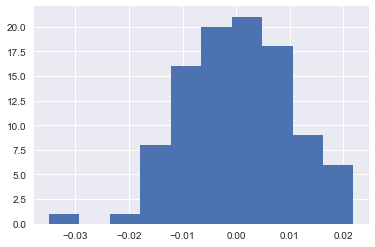

In [60]:
plt.hist(ext_lst)

(array([  1.,   2.,   2.,  17.,  22.,  18.,  17.,   8.,   8.,   5.]),
 array([-0.02884631, -0.02359516, -0.01834401, -0.01309286, -0.0078417 ,
        -0.00259055,  0.0026606 ,  0.00791175,  0.0131629 ,  0.01841406,
         0.02366521]),
 <a list of 10 Patch objects>)

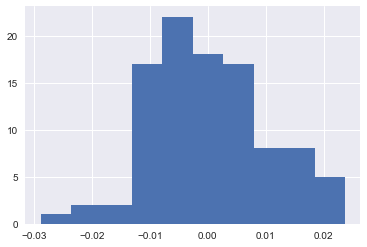

In [61]:
plt.hist(ext_lst2)

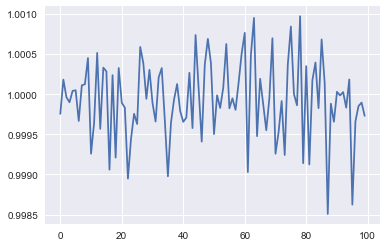

In [107]:
plt.plot(final_pos1)